## Deep CNN Architecture 1


In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver
from cs231n.classifiers.convnet2 import *
from cs231n.classifiers.convnet3 import *
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape


X_val:  (1000L, 3L, 32L, 32L)
X_train:  (49000L, 3L, 32L, 32L)
X_test:  (1000L, 3L, 32L, 32L)
y_val:  (1000L,)
y_train:  (49000L,)
y_test:  (1000L,)


## Loading Pre-trained model

We have saved the parameters of a DeepCNN2 model trained for 10 epochs and which achieved:  
train acc: 0.980000; val_acc: 0.854000  

We will now try to load the parameters back to the same DeepCNN2 model and try get it to work.  

In [6]:
outfile = 'bestparams.npz'
npzfile = np.load(outfile)
print('npzfile.files: {}'.format(npzfile.files))
best_params = npzfile["arr_0"].item()

print best_params.keys()
print best_params[(0, 1, 'gamma')]

npzfile.files: ['arr_0']
[(1, 2, 'W'), (0, 0, 'b'), (1, 1, 'beta'), (1, 0, 'b'), (1, 1, 'gamma'), (2, 0, 'b'), (1, 0, 'beta'), (0, 1, 'b'), (0, 0, 'gamma'), (0, 1, 'beta'), (1, 1, 'W'), (1, 2, 'gamma'), (1, 0, 'W'), (2, 0, 'gamma'), (1, 1, 'b'), (0, 1, 'W'), (0, 0, 'W'), (2, 0, 'W'), (2, 1, 'W'), (1, 0, 'gamma'), (1, 2, 'b'), (0, 0, 'beta'), (1, 2, 'beta'), (2, 0, 'beta'), (0, 1, 'gamma'), (2, 1, 'b')]
[[ 1.04201615  0.98802483  1.01392901  1.03879774  1.00069976  1.02276301
   1.00851595  1.02322447  1.02012813  1.03900766  0.98600054  0.97408313
   0.97058344  0.96740896  0.97963089  1.05948758  1.02007115  0.91581202
   1.02139342  1.0138433   0.98453218  0.98601609  0.95361978  1.00722933
   0.92425257  1.02343643  1.03483903  0.99520469  1.04087758  0.98012888
   1.02206182  1.03480077  1.03159964  1.02654779  0.98091561  0.99859691
   0.97717685  0.97969919  1.0334568   0.97638208  1.00265729  0.98508143
   0.98859704  0.94195509  0.94429696  1.00561011  0.99463284  1.00581086
  

In [16]:
from cs231n.classifiers.convnet3 import *

outfile = 'bestparams.npz'
npzfile = np.load(outfile)
best_params = npzfile["arr_0"].item()

num_train = 1000
small_data = {
  'X_test1': data['X_train'][:num_train],
  'y_test1': data['y_train'][:num_train],
  'X_test2': data['X_train'][num_train+1:num_train*2],
  'X_test2': data['y_train'][num_train+1:num_train*2],
}

# This was the model that was trained
model = DeepConvNet3(num_filters=[[64,64],[128,128,128]], filter_sizes=[[3,3],[3,3,3]], weight_scale=1e-2, 
                    hidden_dim=500, verbose=False, reg = 0.001, use_batchnorm=True)

print model.params.keys()

model.params = best_params  # Transfer parameters from pre-trained model

t1 = time()
y_test_pred = np.argmax(model.loss(small_data['X_test1']), axis=1)
t2 = time()

print 'Test set accuracy: ', (y_test_pred == small_data['y_test1']).mean()
print 'Testing Time: %fs' % (t2 - t1)

[(1, 2, 'W'), (0, 0, 'b'), (1, 1, 'beta'), (1, 0, 'b'), (1, 1, 'gamma'), (2, 0, 'b'), (1, 0, 'beta'), (0, 1, 'b'), (0, 0, 'gamma'), (0, 1, 'beta'), (1, 1, 'W'), (1, 2, 'gamma'), (1, 0, 'W'), (2, 0, 'gamma'), (1, 1, 'b'), (0, 1, 'W'), (0, 0, 'W'), (2, 0, 'W'), (2, 1, 'W'), (1, 0, 'gamma'), (1, 2, 'b'), (0, 0, 'beta'), (1, 2, 'beta'), (2, 0, 'beta'), (0, 1, 'gamma'), (2, 1, 'b')]
Test set accuracy:  0.102
Testing Time: 21.062000s


In [39]:
from cs231n.classifiers.convnet3 import *

outfile = 'bestparams.npz'
npzfile = np.load(outfile)
print('npzfile.files: {}'.format(npzfile.files))
best_params = npzfile["arr_0"].item()

best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

network_architectures =  {'{CONV064}x2-Pool-{CONV128}x3-Pool':([[64,64],[128,128,128]],[[3,3],[3,3,3]])
                        }
learning_rates = [2e-4*0.95**10]
regularization_strengths = [0.001]

for label, network in sorted(network_architectures.iteritems()):
    print 'CONV Network:', label
    for i in range(1):
        print 'Run number: %d '% i
        n, f = network
        version = 1
        for lr in learning_rates:
            for reg in regularization_strengths:
                print 'Learning rate: %e Reg Strength: %e '% (lr, reg)
                num_filters, filter_sizes = network
                model = DeepConvNet3(num_filters=num_filters, filter_sizes=filter_sizes, weight_scale=1e-2, 
                                     hidden_dim=500, reg=reg, verbose=False, use_batchnorm=True)
 
                model.params = best_params  # Transfer parameters from models trained for 10 epochs

                t1 = time()               
                solver = Solver(model, data,
                    num_epochs=10, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    }, lr_decay=0.95, verbose=True, print_every=20)
                solvers[(label,i,version,lr,reg)] = solver
                solver.train()
                t2 = time()

                times[(label,i,version,lr,reg)] = (t2 - t1)
                print 'Training Time: %fs' % (t2 - t1)
        
                results[(label,i,version,lr,reg)] = solver.best_val_acc
  
                if (solver.best_val_acc > best_val):
                    best_val = solver.best_val_acc
                    best_model = model
            
                version += 1

npzfile.files: ['arr_0']
CONV Network: {CONV064}x2-Pool-{CONV128}x3-Pool
Run number: 0 
Learning rate: 1.197474e-04 Reg Strength: 1.000000e-03 
(Iteration 1 / 9800) loss: 0.242890
(Epoch 0 / 10) train acc: 0.250000; val_acc: 0.230000
(Iteration 21 / 9800) loss: 0.428763
(Iteration 41 / 9800) loss: 0.216675
(Iteration 61 / 9800) loss: 0.201806
(Iteration 81 / 9800) loss: 0.232336
(Iteration 101 / 9800) loss: 0.182451
(Iteration 121 / 9800) loss: 0.173297
(Iteration 141 / 9800) loss: 0.190168
(Iteration 161 / 9800) loss: 0.279800
(Iteration 181 / 9800) loss: 0.212770
(Iteration 201 / 9800) loss: 0.209460
(Iteration 221 / 9800) loss: 0.224360
(Iteration 241 / 9800) loss: 0.206679
(Iteration 261 / 9800) loss: 0.210860
(Iteration 281 / 9800) loss: 0.212197
(Iteration 301 / 9800) loss: 0.235277
(Iteration 321 / 9800) loss: 0.187021
(Iteration 341 / 9800) loss: 0.308321
(Iteration 361 / 9800) loss: 0.201158
(Iteration 381 / 9800) loss: 0.248456
(Iteration 401 / 9800) loss: 0.217838
(Iteration

{CONV064}x2-Pool-{CONV128}x3-Pool (Version 1) lr = 1.197474e-04; reg = 1.000000e-03, val accuracy: 0.858000
best validation accuracy achieved during cross-validation: 0.858000



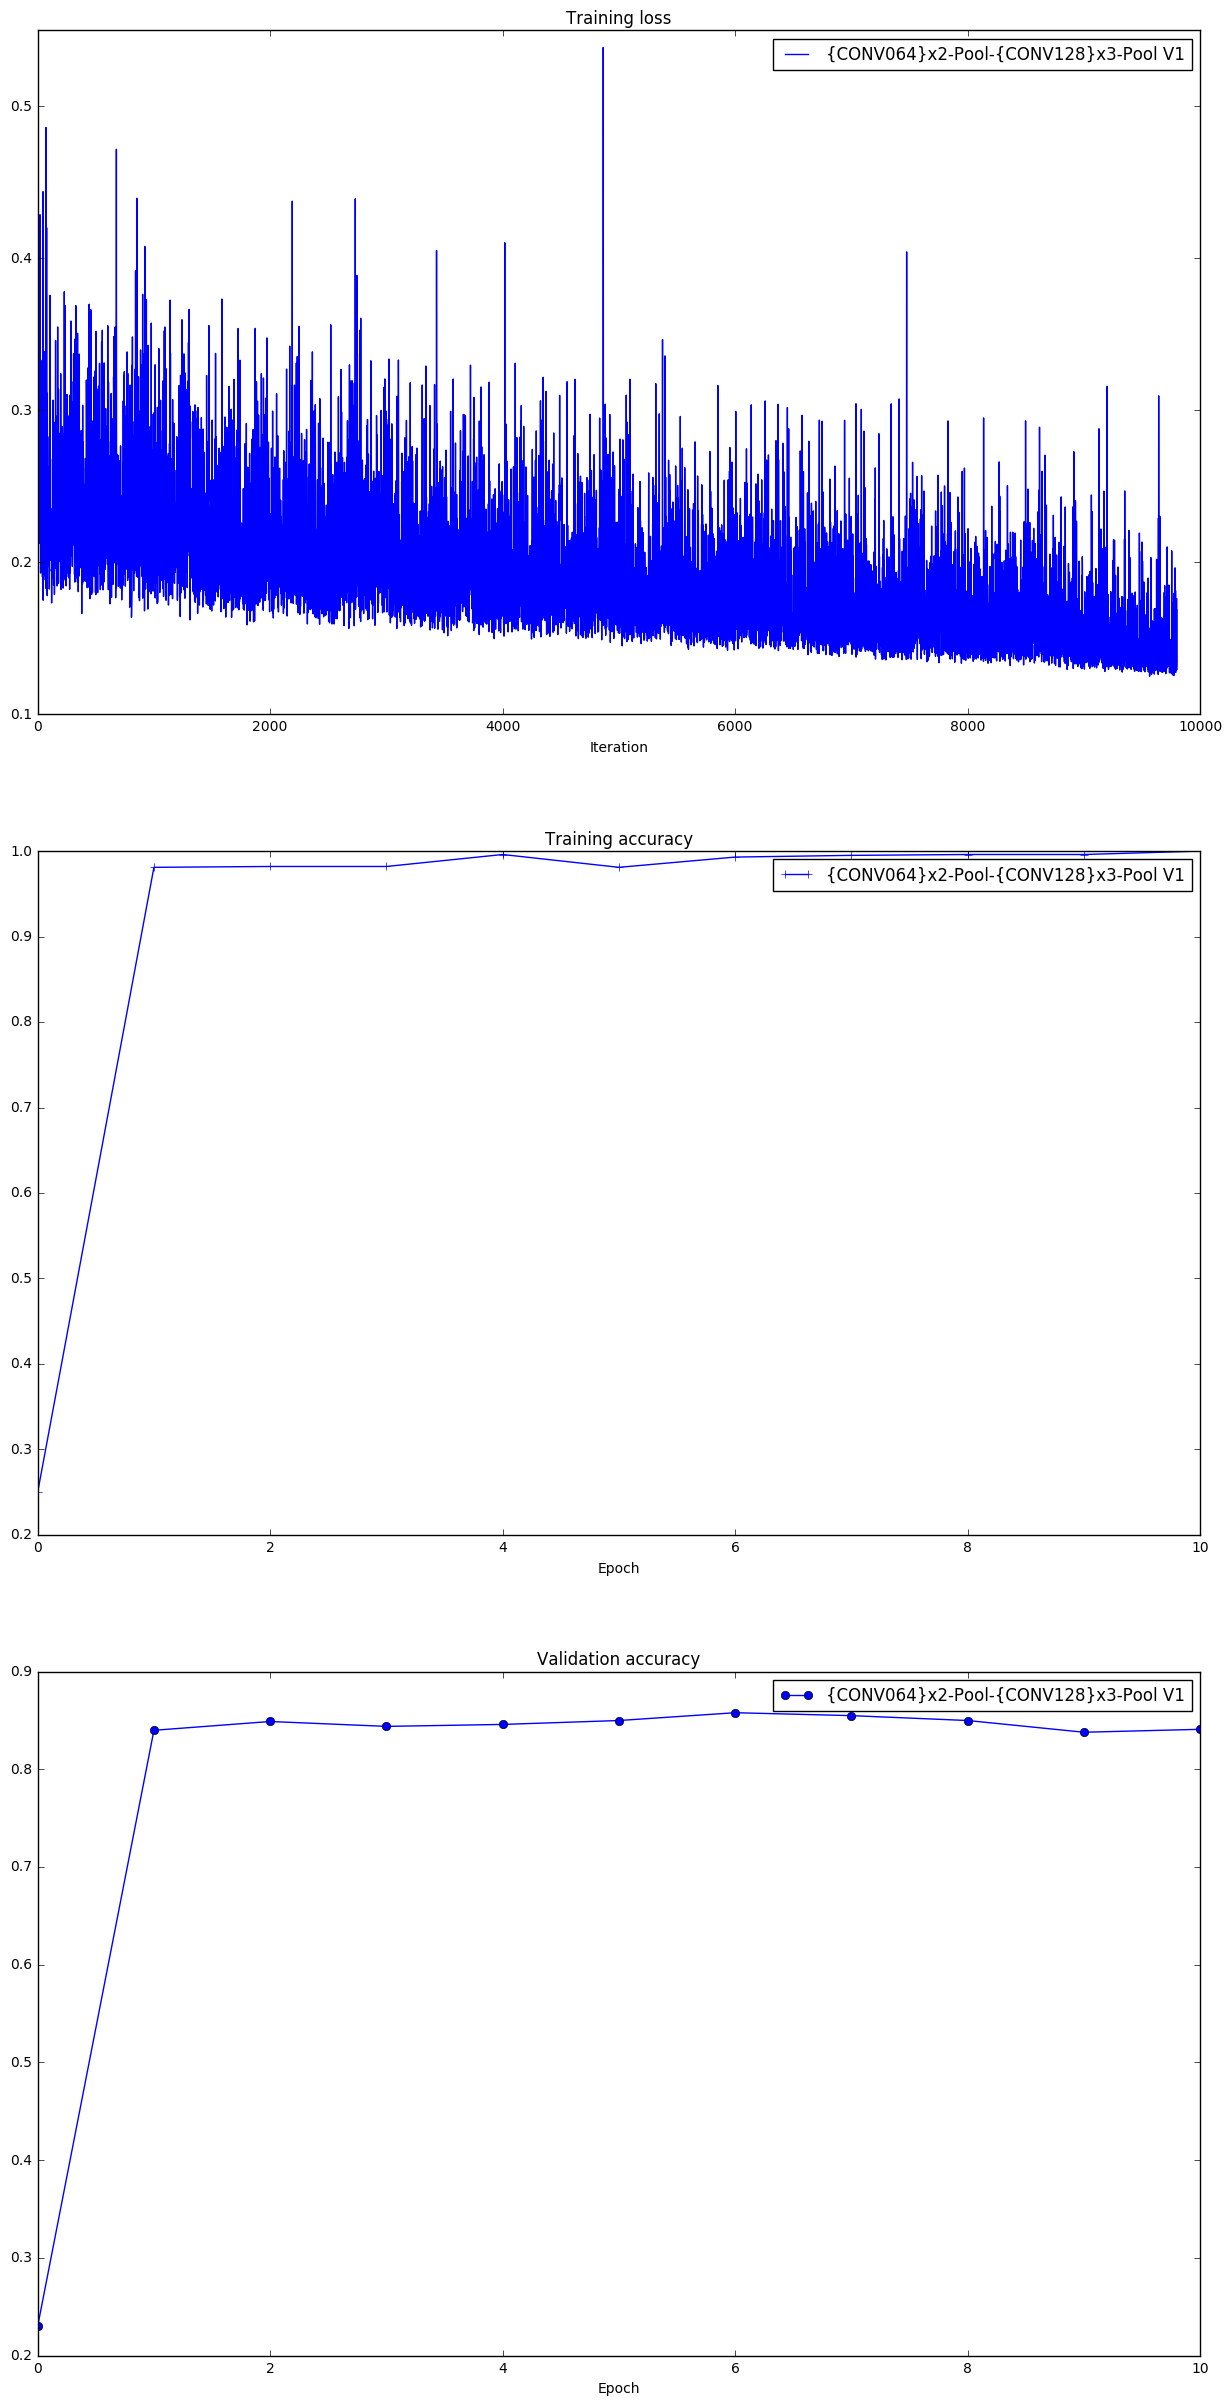

In [40]:
# Print out results.
v = 1
for param,accuracy in sorted(results.iteritems()):
    architecture, i, version, lr, reg = param
    print '%s (Version %d) lr = %e; reg = %e, val accuracy: %f' % (architecture, version, lr, reg, accuracy)
    v += 1
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

print 

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for items, solver in solvers.iteritems():
  label = "%s V%d" % (items[0], items[2])
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, '-', label=label)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-+', label=label)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=label)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='best', ncol=2)
plt.gcf().set_size_inches(15, 30)
plt.show()

In [16]:
print best_model.params.keys()
outfile = 'bestparams_64x2_128x3_20epochs.npz'

np.savez(outfile, best_model.params)

[(1, 2, 'W'), (0, 0, 'b'), (1, 1, 'beta'), (1, 0, 'b'), (1, 1, 'gamma'), (2, 0, 'b'), (1, 0, 'beta'), (0, 1, 'b'), (0, 0, 'gamma'), (0, 1, 'beta'), (1, 1, 'W'), (1, 2, 'gamma'), (1, 0, 'W'), (2, 0, 'gamma'), (1, 1, 'b'), (0, 1, 'W'), (0, 0, 'W'), (2, 0, 'W'), (2, 1, 'W'), (1, 0, 'gamma'), (1, 2, 'b'), (0, 0, 'beta'), (1, 2, 'beta'), (2, 0, 'beta'), (0, 1, 'gamma'), (2, 1, 'b')]
npzfile.files: ['arr_0']
npzfile["arr_0"]: {(1, 2, 'W'): array([[[[ -1.82068162e-03,  -3.73778073e-03,   2.14280225e-02],
         [  5.32289827e-03,  -2.14348249e-02,   2.29300046e-03],
         [  2.60311924e-03,  -3.00912978e-03,   1.12715131e-02]],

        [[  2.73835845e-03,   1.79987289e-02,   1.20896650e-02],
         [ -8.98718776e-04,   5.02746506e-03,   1.44153470e-02],
         [  1.46221006e-02,   9.50852409e-03,   1.63232535e-02]],

        [[ -8.11589707e-05,  -2.75111874e-03,  -1.62203480e-02],
         [  1.81057095e-03,   1.80571427e-04,  -3.63021456e-02],
         [ -1.29110804e-02,  -2.631705

In [3]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2, dropout=0.5, seed=123, use_batchnorm=True, verbose=False)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=1)
solver.train()

print solver.best_params

(Iteration 1 / 40) loss: 2.320248
(Epoch 0 / 20) train acc: 0.210000; val_acc: 0.130000
(Iteration 2 / 40) loss: 2.240146
(Epoch 1 / 20) train acc: 0.230000; val_acc: 0.141000
(Iteration 3 / 40) loss: 2.073038
(Iteration 4 / 40) loss: 2.164493
(Epoch 2 / 20) train acc: 0.350000; val_acc: 0.159000
(Iteration 5 / 40) loss: 1.841893
(Iteration 6 / 40) loss: 2.001265
(Epoch 3 / 20) train acc: 0.430000; val_acc: 0.178000
(Iteration 7 / 40) loss: 1.712479
(Iteration 8 / 40) loss: 1.859675
(Epoch 4 / 20) train acc: 0.470000; val_acc: 0.182000
(Iteration 9 / 40) loss: 1.620667
(Iteration 10 / 40) loss: 1.747536
(Epoch 5 / 20) train acc: 0.520000; val_acc: 0.189000
(Iteration 11 / 40) loss: 1.547741
(Iteration 12 / 40) loss: 1.655147
(Epoch 6 / 20) train acc: 0.580000; val_acc: 0.196000
(Iteration 13 / 40) loss: 1.483477
(Iteration 14 / 40) loss: 1.575911
(Epoch 7 / 20) train acc: 0.630000; val_acc: 0.198000
(Iteration 15 / 40) loss: 1.427896
(Iteration 16 / 40) loss: 1.507981
(Epoch 8 / 20) tr

In [7]:
t1 = time()
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
t2 = time()

print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()
print 'Testing Time: %fs' % (t2 - t1)

print model.params
print model.reg
print model.dtype 
print model.use_batchnorm
print model.use_dropout
print model.bn_params
print model.dropout_param 

Test set accuracy:  0.194
Testing Time: 2.969000s
{'b2': array([ -2.38565283e-18,  -2.51791071e-18,  -8.98577285e-19,
        -5.49366589e-18,   4.20333719e-18,  -5.66752684e-18,
         1.59620005e-18,  -9.96717302e-19,  -8.04520747e-20,
         2.50040906e-18,   3.04999646e-18,   1.37295568e-19,
         2.57264574e-18,  -9.83060595e-19,   2.34365943e-18,
        -3.39409891e-18,   2.92541374e-18,  -8.10509473e-19,
         2.14056845e-18,  -1.48959672e-18,   4.94457985e-18,
        -2.17123295e-18,  -6.10839179e-19,  -5.09098566e-18,
        -3.98648750e-18,  -3.32522665e-18,   9.60173934e-20,
        -3.45467815e-18,  -1.61858355e-18,  -2.87372675e-19,
         4.89572071e-19,   2.08515773e-18,   5.08177680e-20,
         1.04845499e-18,  -6.06303391e-18,  -2.14224212e-18,
         1.74464377e-18,  -8.73725868e-20,   1.08703625e-18,
         2.29177753e-18,   1.53361576e-18,  -1.62836878e-18,
        -2.92880426e-18,  -5.26935427e-20,  -3.76569707e-18,
         1.21206443e-18,   3

In [8]:
model_test = ThreeLayerConvNet(weight_scale=1e-2, dropout=0.5, seed=123, use_batchnorm=True, verbose=False)
model_test.params=model.params

print model_test.params
print model_test.reg
print model_test.dtype 
print model_test.use_batchnorm
print model_test.use_dropout
print model_test.bn_params
print model_test.dropout_param 

t1 = time()
y_test_pred = np.argmax(model_test.loss(data['X_test']), axis=1)
t2 = time()

print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()
print 'Testing Time: %fs' % (t2 - t1)

{'b2': array([ -2.38565283e-18,  -2.51791071e-18,  -8.98577285e-19,
        -5.49366589e-18,   4.20333719e-18,  -5.66752684e-18,
         1.59620005e-18,  -9.96717302e-19,  -8.04520747e-20,
         2.50040906e-18,   3.04999646e-18,   1.37295568e-19,
         2.57264574e-18,  -9.83060595e-19,   2.34365943e-18,
        -3.39409891e-18,   2.92541374e-18,  -8.10509473e-19,
         2.14056845e-18,  -1.48959672e-18,   4.94457985e-18,
        -2.17123295e-18,  -6.10839179e-19,  -5.09098566e-18,
        -3.98648750e-18,  -3.32522665e-18,   9.60173934e-20,
        -3.45467815e-18,  -1.61858355e-18,  -2.87372675e-19,
         4.89572071e-19,   2.08515773e-18,   5.08177680e-20,
         1.04845499e-18,  -6.06303391e-18,  -2.14224212e-18,
         1.74464377e-18,  -8.73725868e-20,   1.08703625e-18,
         2.29177753e-18,   1.53361576e-18,  -1.62836878e-18,
        -2.92880426e-18,  -5.26935427e-20,  -3.76569707e-18,
         1.21206443e-18,   3.45866638e-20,  -1.64889791e-18,
        -7.152524